# Time Series Prediction

Clemence Vast - 2020

## Objectives


We want to predict the next month for items and shops
- load and clean data
- visualize different data representations
- select interesting data
- build a CNN
- train one or multiple items-shop series in the CNN
- evaluate the CNN and analyze results

## Import libraries

In [44]:
import torch
from torchsummary import summary
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

## Load DataFrame and visualize info

In [45]:
train_csv = pd.read_csv("./sales_train.csv", parse_dates=['date'])
print(train_csv.head(10))

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-02-01               0       59    22154      999.00           1.0
1 2013-03-01               0       25     2552      899.00           1.0
2 2013-05-01               0       25     2552      899.00          -1.0
3 2013-06-01               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0
5 2013-10-01               0       25     2564      349.00           1.0
6 2013-02-01               0       25     2565      549.00           1.0
7 2013-04-01               0       25     2572      239.00           1.0
8 2013-11-01               0       25     2572      299.00           1.0
9 2013-03-01               0       25     2573      299.00           3.0


In [46]:
print(train_csv.info())
print(train_csv.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None
(2935849, 6)


## Preparing and cleaning data

In [47]:
## let's remove negative values for sales
train_csv.query('item_price > 0', inplace=True)
print(train_csv.shape)

(2935848, 6)


We want to check if there are some rare exceptions in the values and filter them

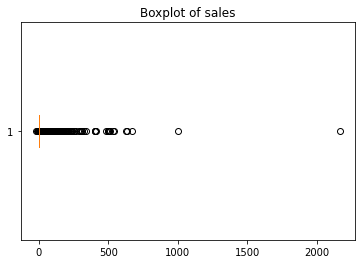

In [48]:
fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot of sales')
ax1.boxplot(train_csv.item_cnt_day, vert=False)
plt.show()

We see that values tend to be under 1000 except 2 values. To clean a little bit our dataset we're going to remove those values.

In [49]:
train_csv.query('item_cnt_day < 1000', inplace=True)

In [50]:
# group items by date blocks
df_date = pd.DataFrame(train_csv.groupby(["date_block_num", "shop_id", "item_id", "item_price"], as_index=False)['item_cnt_day'].sum())
df_date.head(5)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,0,32,221.0,6.0
1,0,0,33,347.0,3.0
2,0,0,35,247.0,1.0
3,0,0,43,221.0,1.0
4,0,0,51,127.0,1.0


## Visualize by month

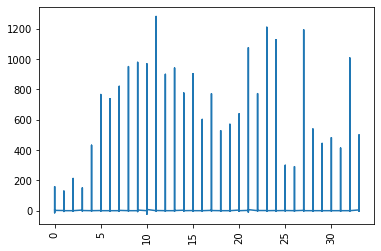

In [51]:
plt.plot( "date_block_num", "item_cnt_day", data = df_date.sort_values(by="date_block_num"))

plt.xticks(rotation=90)

plt.show()

## Normalizing

In [52]:
data = np.array(train_csv["item_cnt_day"])
scaler = MinMaxScaler(feature_range=(0, 1))
train_normalized = scaler.fit_transform(data.reshape(-1, 1))
train_csv["item_cnt_day_norm"] = train_normalized
train_csv

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_day_norm
0,2013-02-01,0,59,22154,999.00,1.0,0.033285
1,2013-03-01,0,25,2552,899.00,1.0,0.033285
2,2013-05-01,0,25,2552,899.00,-1.0,0.030391
3,2013-06-01,0,25,2554,1709.05,1.0,0.033285
4,2013-01-15,0,25,2555,1099.00,1.0,0.033285
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,0.033285
2935845,2015-09-10,33,25,7460,299.00,1.0,0.033285
2935846,2015-10-14,33,25,7459,349.00,1.0,0.033285
2935847,2015-10-22,33,25,7440,299.00,1.0,0.033285


## Cleaning

Let's check the data and filter when we see unuseful values

In [53]:
train_csv = train_csv.groupby(['date_block_num',"shop_id", "item_id"]).agg({"item_cnt_day_norm":"count"}, as_index=False)
train_csv

item_cnt_day_norm
date_block_num shop_id item_id                   
0              0       32                       4
                       33                       3
                       35                       1
                       43                       1
                       51                       2
...                                           ...
33             59      22087                    3
                       22088                    2
                       22091                    1
                       22100                    1
                       22102                    1

[1609123 rows x 1 columns]

In [54]:
## We could group all values together, by date block

train_grouped = train_csv.sort_values('date_block_num').groupby(['date_block_num'], as_index=True)
train_grouped = train_grouped.agg({'item_cnt_day_norm':"mean"})
train_grouped.rename(columns={"item_cnt_day_norm":"sales_norm"}, inplace=True)
train_grouped.head()

,sales_norm
date_block_num,
0,1.829843
1,1.812180
2,1.896729
3,1.722409
4,1.721668


## Split data between train and test

In [55]:
test_proportion = 0.4
train, test = train_test_split(train_grouped, test_size=test_proportion)

print('Train proportion : {:.0f}%'.format((1-test_proportion)*100))
print('Validation proportion : {:.0f}%'.format(test_proportion*100))

Train proportion : 60%
Validation proportion : 40%


In [57]:
# split to build a window
def split_window(window, n_steps):
    X, y = list(), list()
    for i in range(len(window)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the window
        if end_ix > len(window)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = window[i:end_ix], window[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [58]:
window = 12

train_x,train_y = split_window(train.sales_norm.values,window)
valid_x,valid_y = split_window(test.sales_norm.values,window)


In [59]:
## Creates the Dataset and extracts it

class DatasetSales(Dataset):
    def __init__(self,item_group,target):
        self.item_group = item_group
        self.target = target
    
    def __len__(self):
        return len(self.item_group)
    
    def __getitem__(self,idx):
        item = self.item_group[idx]
        label = self.target[idx]
        return item,label

In [60]:
## CNN with two Conv 1 D

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv1d(12,100,kernel_size=1)
        self.conv2 = nn.Conv1d(100,64,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64*2,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x
    

In [62]:
## preparing Train
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = ConvNet().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [63]:
# Torch summary gives a small summary of the Neural Network with the input size

summary(cnn,[12,1])

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 100, 1]              1,300
├─ReLU: 1-2                              [-1, 100, 1]              --
├─Conv1d: 1-3                            [-1, 64, 1]               6,464
├─ReLU: 1-4                              [-1, 64, 1]               --
├─Linear: 1-5                            [-1]                      6,450
├─ReLU: 1-6                              [-1]                      --
├─Linear: 1-7                            [-1]                      51
Total params: 14,265
Trainable params: 14,265
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.06


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 100, 1]              1,300
├─ReLU: 1-2                              [-1, 100, 1]              --
├─Conv1d: 1-3                            [-1, 64, 1]               6,464
├─ReLU: 1-4                              [-1, 64, 1]               --
├─Linear: 1-5                            [-1]                      6,450
├─ReLU: 1-6                              [-1]                      --
├─Linear: 1-7                            [-1]                      51
Total params: 14,265
Trainable params: 14,265
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.06

In [64]:
## Create sets and Data Loaders

trainset = DatasetSales(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
validset = DatasetSales(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=2,shuffle=False)
validationloader = torch.utils.data.DataLoader(trainset,batch_size=2,shuffle=False)


In [65]:
dataset_loaders = {"train": trainloader, "test": validationloader}


In [67]:
train_losses = []
valid_losses = []
def train_fn():
    """ Train part with dataloader and train loss"""
    train = dataset_loaders["train"]
    running_loss = .0
    
    cnn.train()
    
    for idx, (inputs,labels) in enumerate(train):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = cnn(inputs.float())
        loss = criterion(preds,labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss : {train_loss}')
    
def test_fn():
    """ Test part with dataloader and test loss"""
    test = dataset_loaders["test"]
    running_loss = .0
    cnn.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = cnn(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(test)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss : {valid_loss}')
        

In [69]:
epochs = 200
for epoch in range(epochs):
    print('\nEpochs {}/{}'.format(epoch+1,epochs))
    train_fn()
    test_fn()


Epochs 1/200
train_loss : 0.005800789687782526
valid_loss : 0.005680937384524254

Epochs 2/200
train_loss : 0.005792020820081234
valid_loss : 0.005672044260498986

Epochs 3/200
train_loss : 0.005782362073659897
valid_loss : 0.005664607531368174

Epochs 4/200
train_loss : 0.005771523807197809
valid_loss : 0.00565666207865399

Epochs 5/200
train_loss : 0.00575777143239975
valid_loss : 0.005649482659421245

Epochs 6/200
train_loss : 0.005749915260821581
valid_loss : 0.005642501647008917

Epochs 7/200
train_loss : 0.005738419014960527
valid_loss : 0.005635152305306744

Epochs 8/200
train_loss : 0.005733638070523739
valid_loss : 0.00562821447569841

Epochs 9/200
train_loss : 0.005723181180655956
valid_loss : 0.005621239036179086

Epochs 10/200
train_loss : 0.005710151512175798
valid_loss : 0.005614784494895496

Epochs 11/200
train_loss : 0.005704841576516628
valid_loss : 0.005608896266366625

Epochs 12/200
train_loss : 0.0056931329891085625
valid_loss : 0.005603000190574335

Epochs 13/200


## Evaluation of the model

We want to print the Loss for both training and validation, to check if the model learned correctly from the features and detect overfitting.

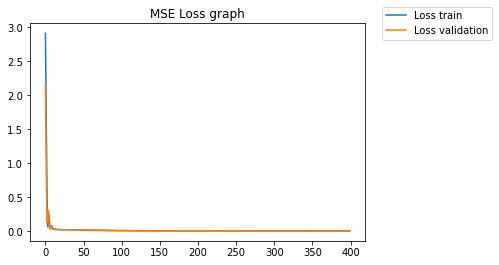

In [70]:
plt.plot(train_losses,label='Loss train')
plt.plot(valid_losses,label='Loss validation')
plt.title('MSE Loss graph')
plt.legend(bbox_to_anchor=(1.05, 1), loc= 'center left', borderaxespad=0.)
plt.show()

In [72]:
targetX , targetY = split_window(train.sales_norm.values,window)
inputs = targetX.reshape(targetX.shape[0],targetX.shape[1],1)

cnn.eval()
prediction = []
batch_size = 2
iterations =  int(inputs.shape[0]/2)

for i in range(iterations):
    preds = cnn(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds.detach().numpy())

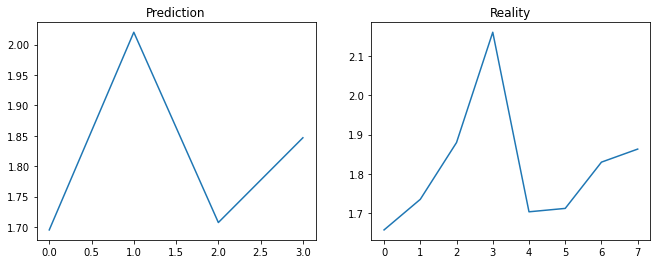

In [74]:
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('Prediction')
ax[0].plot(prediction)
ax[1].set_title('Reality')
ax[1].plot(targetY)
plt.show()

## Analysis

Of course my model is not really representing the reality and is not complete, I would normally need to create a model by item-shop duo and then connect them all together for example. To work with a bigger dataset and add additional values I could also use a k-fold technique. Maybe convolutional layers are also not the best way to predict this kind of information.
Overall, the Loss looks good but I'm not sure it would with a different dataset of values. 

If I had more time here's what I wouldve done:
- Build a model for each item-shop duo
- Connect them all with a fully connected layer
- Build a model by shop (for all items)
- Build a model by item (for all shops)

I could've compare all those models and select my favorite one or analyse them too.